# Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T

# Network Architecture

In [38]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 320x320

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 160x160

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 80x80

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 40x40

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(512, 128)

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  # batch_size, 128)
        return x

In [39]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, anchor, positive, negative):
        anchor_out = self.embedding_net(anchor)
        positive_out = self.embedding_net(positive)
        negative_out = self.embedding_net(negative)
        return anchor_out, positive_out, negative_out

In [40]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        d_positive = F.pairwise_distance(anchor, positive, p=2)
        d_negative = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(d_positive - d_negative + self.margin)
        return loss.mean()

# Dataset Design

In [41]:
class ImageTripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.anchor_dir = os.path.join(root_dir, "anchor")
        self.positive_dir = os.path.join(root_dir, "positive")
        self.negative_dir = os.path.join(root_dir, "negative")

        self.filenames = sorted(os.listdir(self.anchor_dir))
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        anchor_path = os.path.join(self.anchor_dir, self.filenames[idx])
        positive_path = os.path.join(self.positive_dir, self.filenames[idx])
        negative_path = os.path.join(self.negative_dir, self.filenames[idx])

        anchor = Image.open(anchor_path).convert("RGB")
        positive = Image.open(positive_path).convert("RGB")
        negative = Image.open(negative_path).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

In [42]:
transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
])

dataset = ImageTripletDataset(root_dir="triplet_data", transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Training Loop

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device)

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [44]:
from torchsummary import summary

print("Summary for EmbeddingNet:")
embedding_net_instance = EmbeddingNet().to(device)
summary(embedding_net_instance, (3, 640, 640), device=str(device))

Summary for EmbeddingNet:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 640, 640]           2,432
              ReLU-2         [-1, 32, 640, 640]               0
         MaxPool2d-3         [-1, 32, 320, 320]               0
            Conv2d-4         [-1, 64, 320, 320]          51,264
              ReLU-5         [-1, 64, 320, 320]               0
         MaxPool2d-6         [-1, 64, 160, 160]               0
            Conv2d-7        [-1, 128, 160, 160]          73,856
              ReLU-8        [-1, 128, 160, 160]               0
         MaxPool2d-9          [-1, 128, 80, 80]               0
           Conv2d-10          [-1, 256, 80, 80]         295,168
             ReLU-11          [-1, 256, 80, 80]               0
        MaxPool2d-12          [-1, 256, 40, 40]               0
           Conv2d-13          [-1, 512, 40, 40]       1,180,160
             

In [45]:
num_epochs = 128
loss_result = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for anchor, positive, negative in loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()
        anchor_out, positive_out, negative_out = model(anchor, positive, negative)

        loss = triplet_loss(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    loss_result.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/128] - Loss: 0.9846
Epoch [2/128] - Loss: 0.9392
Epoch [3/128] - Loss: 0.7113
Epoch [4/128] - Loss: 0.6478
Epoch [5/128] - Loss: 0.9072
Epoch [6/128] - Loss: 0.5996
Epoch [7/128] - Loss: 0.6113
Epoch [8/128] - Loss: 0.5820
Epoch [9/128] - Loss: 0.4865
Epoch [10/128] - Loss: 0.4608
Epoch [11/128] - Loss: 0.4773
Epoch [12/128] - Loss: 0.4803
Epoch [13/128] - Loss: 0.3847
Epoch [14/128] - Loss: 0.3868
Epoch [15/128] - Loss: 0.4011
Epoch [16/128] - Loss: 0.3570
Epoch [17/128] - Loss: 0.4055
Epoch [18/128] - Loss: 0.3189
Epoch [19/128] - Loss: 0.3494
Epoch [20/128] - Loss: 0.2448
Epoch [21/128] - Loss: 0.2410
Epoch [22/128] - Loss: 0.2624
Epoch [23/128] - Loss: 0.2285
Epoch [24/128] - Loss: 0.3231
Epoch [25/128] - Loss: 0.2970
Epoch [26/128] - Loss: 0.2350
Epoch [27/128] - Loss: 0.2643
Epoch [28/128] - Loss: 0.2173
Epoch [29/128] - Loss: 0.5193
Epoch [30/128] - Loss: 0.2759
Epoch [31/128] - Loss: 0.3954
Epoch [32/128] - Loss: 0.2696
Epoch [33/128] - Loss: 0.2751
Epoch [34/128] - Lo

# Plot the result

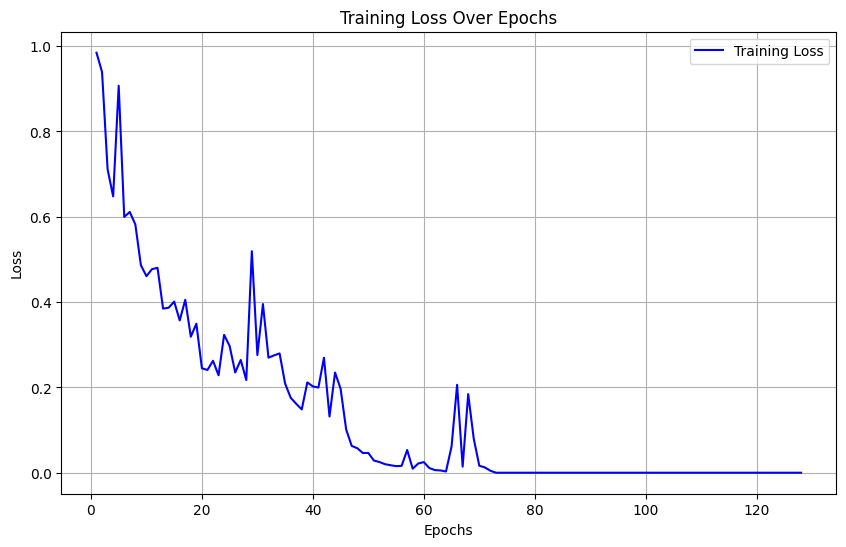

In [46]:
epochs = range(1, len(loss_result) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_result, 'b', label='Training Loss')


plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.show()

plt.savefig('loss_curve.png')
plt.close()

# Evaluation

In [54]:
def classify_by_distance(anchor_path, test_path, model, threshold=0.8, device="cuda"):
    model = model.to(device)

    anchor_img = Image.open(anchor_path).convert("RGB")
    test_img = Image.open(test_path).convert("RGB")

    anchor_tensor = transform(anchor_img).unsqueeze(0).to(device)
    test_tensor = transform(test_img).unsqueeze(0).to(device)

    with torch.no_grad():
        anchor_embed = model(anchor_tensor)
        test_embed = model(test_tensor)
        dist = F.pairwise_distance(anchor_embed, test_embed).item()

    print(f"Distance: {dist:.4f}")
    if dist < threshold:
        return "Positive (Same class)"
    else:
        return "Negative (Different class)"

result = classify_by_distance("triplet_data/anchor/4.jpg", "triplet_data/positive/22.jpg", embedding_net, threshold=1.0)
print("Result:", result)

Distance: 14.1334
Result: Negative (Different class)


# Save the model

In [48]:
torch.save(embedding_net.state_dict(), "embedding_net.pth")